# NTU ADL 2023 Fall HW2 - MT5 Fine-tuning for Title Generation
- written by Chih-Han Yang
- inspired by [Link](https://github.com/KrishnanJothi/MT5_Language_identification_NLP/blob/main/MT5_fine-tuning.ipynb)
- executed on google - colab
### Check the system resource

In [ ]:
! nvidia-smi

Mon Nov  6 10:03:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import Required Library and Set Arguments
1. Checks if a CUDA device (GPU) is available and prints the result.
2. Imports the torch library for PyTorch, json for handling JSON data, and math for mathematical operations.
3. Imports components from the accelerate library for hardware acceleration during training.
4. Imports necessary components from the transformers library for working with pre-trained language models.
5. Imports a function (get_rouge) for computing ROUGE scores, which are used for evaluating text generation tasks.
6. Imports the tqdm library for creating progress bars, matplotlib for plotting, pandas for data manipulation, and argparse for handling command-line arguments.
7. Defines a function named parse_args() which sets up command-line arguments for customizing the fine-tuning process. These arguments include file paths, hyperparameters, and settings related to the training process.
    - (ps, Note that argparse are meant to be run from the command line, since it's a integrated kernel in the ipynb file, use ```args = parser.parse_known_args()[0]``` to resolve it.)
    - (ps, Change the path arguments if you're using this code on a different platform.)


In [1]:
import torch
# check if there's any cuda device available
print(torch.cuda.is_available())

import json
import math

from accelerate import Accelerator
from accelerate.utils import set_seed

import transformers
from transformers import (
    AutoTokenizer,
    MT5ForConditionalGeneration,
    GenerationConfig,
    get_linear_schedule_with_warmup,
)
from tw_rouge import get_rouge

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import argparse

def parse_args():
    parser = argparse.ArgumentParser(description = "Finetune a mT5 model on Title Generation")
    parser.add_argument("--train_file", type=str, default="/content/data/train.jsonl")
    parser.add_argument("--validation_file", type=str, default="/content/data/public.jsonl")
    parser.add_argument("--result_file", type=str, default="/content/result.jsonl")
    parser.add_argument("--max_output_length", type=int, default=64)
    parser.add_argument("--max_input_length", type=int, default=256)
    parser.add_argument("--model_name_or_path", type=str, default="google/mt5-small")
    parser.add_argument("--learning_rate", type=float, default=1e-3)
    parser.add_argument("--num_train_epochs", type=int, default=6)
    parser.add_argument("--output_dir", type=str, default="/content/model/")
    parser.add_argument("--per_device_train_batch_size", type=int, default=1)
    parser.add_argument("--per_device_eval_batch_size", type=int, default=1)
    parser.add_argument("--gradient_accumulation_steps", type=int, default=16)
    parser.add_argument("--seed", type=int, default=20231104)
    parser.add_argument("--weight_decay", type=float, default=0.0)


    args = parser.parse_known_args()[0]
    if args.train_file is None or args.validation_file is None or args.result_file is None:
        raise ValueError("Need train file, validation file, and the result file specification")
    else:
        # neither do train_file nor validation file is None, so
        extension = args.train_file.split(".")[-1] # to see what extension the file is
        print(extension)
        assert extension == "jsonl", "train_file should be a jsonl file"
        extension = args.validation_file.split(".")[-1] # to see what extension the file is
        assert extension == "jsonl", "validation_file should be a jsonl file"
        extension = args.result_file.split(".")[-1] # to see what extension the file is
        assert extension == "jsonl", "result_file should be a jsonl file"
    return args

True


/usr/local/lib/python3.10/dist-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)


### Setup and Configuration
The following code is responsible for initializing the training process with the specified configuration, setting up hardware acceleration, adjusting logging levels, and potentially setting a random seed for reproducibility.

In [ ]:
args = parse_args()

# acclerator setup
accelerator_log_kwargs = {}
accelerator = Accelerator(gradient_accumulation_steps=args.gradient_accumulation_steps, **accelerator_log_kwargs)

if accelerator.is_local_main_process:
    transformers.utils.logging.set_verbosity_info()
else:
    transformers.utils.logging.set_verbosity_error()

# If passed along, set the training seed now.
if args.seed is not None:
    set_seed(args.seed)

### Data Preprocessing
This code segment performs the following operations:

1. Loads training and validation data from JSON files.
2. Cleans the data by removing duplicate entries.
3. Removes specific characters from the text. (Spaces and newlines)
4. Calculates maximum text length in the training data.
5. Determines batch sizes for training and evaluation.
6. Adds a prefix to the text in order to specify the starting point.
7. Prints information about the cleaned datasets.

In [2]:
# parsing data
train_df = pd.read_json(args.train_file, lines=True)
eval_df = pd.read_json(args.validation_file, lines=True)

print("=====DATA CLEANING=====")
train_df = train_df.drop_duplicates(subset='title', keep=False).drop_duplicates(subset='maintext', keep=False)
eval_df = eval_df.drop_duplicates(subset='title', keep=False).drop_duplicates(subset='maintext', keep=False)

dropout_symbol = [" ", "\n"]
for s in dropout_symbol:
    train_df["maintext"] = train_df["maintext"].str.replace(s, "")
    eval_df["maintext"] = eval_df["maintext"].str.replace(s, "")

print(max([len(s) for s in train_df["maintext"]]))

train_batch_size = args.per_device_train_batch_size * args.gradient_accumulation_steps
eval_batch_size = args.per_device_eval_batch_size * args.gradient_accumulation_steps

# Adding prefix text to the input, which helps the model to understand the fine-tuning task objective
train_df["maintext"] = '<idf.lang>' + train_df["maintext"]
eval_df["maintext"] = '<idf.lang>' + eval_df["maintext"]
print(f"=====CLEANED TRAIN DATA===== | Shape:{train_df.shape}")
print(train_df.head())
print(f"=====CLEANED VALID DATA===== | Shape:{eval_df.shape}")
print(eval_df.head())

jsonl
=====DATA CLEANING=====
24549
=====CLEANED TRAIN DATA===== | Shape:(21632, 6)
          date_publish                                  title source_domain  \
0  2015-03-02 00:00:00  榜首進台大醫科卻休學 、27歲拿到法國天文博士 李悅寧跌破眾人眼鏡返台任教       udn.com   
1  2015-10-20 00:00:00           「猩人」真有其事？人猿混種曾成功受孕 揭秘前蘇聯可怕實驗       udn.com   
2  2015-12-10 00:00:00                跑步小品／謝謝三浦春馬 再次喚醒我對跑步的熱情       udn.com   
3  2016-04-22 00:00:00       【身體不適特輯（下）】「拉肚子」、「想吐」、「嘔吐」英文怎麼說？       udn.com   
4  2016-04-29 00:00:00                  中職／球彈、好球帶小 投手被打趴百害無一利       udn.com   

                                            maintext  split  id  
0  <idf.lang>從小就很會念書的李悅寧，在眾人殷殷期盼下，以榜首之姿進入臺大醫學院，但始...  train   0  
1  <idf.lang>人類與猩猩混種誕下後代，不一定僅限於科幻電影情節。前蘇聯科學家早在192...  train   1  
2  <idf.lang>從得知三浦春馬離世的消息那刻開始，心中頓時感到很鬱悶，那種很驚訝、很可惜...  train   2  
3  <idf.lang>嗨，歡迎回到【身體不適特輯】的下集，在這集裡，小編會繼續講自己食物中毒的...  train   3  
4  <idf.lang>今年中華職棒官辦熱身賽眾家打者真的打瘋了！數據顯示，官辦熱身賽打了20場...  train   4  
=====CLEANED VALID DATA===== | Shape:(5467, 6

### Tokenizer and Model Initialization for Fine-tuning
The code begins by initializing a tokenizer and a language generation model, loading pre-trained parameters. It configures the hardware accelerator for efficient training. Language identification tokens are defined and added to the tokenizer. The code then provides insights into tokenization and adjusts the model's token embeddings to match the updated vocabulary. This section ensures that both the tokenizer and model are set up optimally for fine-tuning, incorporating a special token for language identification.

In [3]:
# Tokenizer and Model
tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_path,
              use_fast=True,
              trust_remote_code=True,
              cache_dir=args.output_dir
          )
model = MT5ForConditionalGeneration.from_pretrained(
          args.model_name_or_path,
          from_tf=bool(".ckpt" in args.model_name_or_path),
          trust_remote_code=True,
          cache_dir=args.output_dir,
      )

device = accelerator.device
print(f"The device is using: {device}")
model.to(device)

LANG_TOKEN_MAPPING = {'identify language': '<idf.lang>'}
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
print(len(tokenizer))
tokenizer.add_special_tokens(special_tokens_dict)
print(tokenizer.all_special_tokens)
print(len(tokenizer), model.config.vocab_size)
model.resize_token_embeddings(len(tokenizer))

loading configuration file config.json from cache at /content/model/models--google--mt5-small/snapshots/73fb5dbe4756edadc8fbe8c769b0a109493acf7a/config.json
Model config MT5Config {
  "_name_or_path": "google/mt5-small",
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 1024,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "mt5",
  "num_decoder_layers": 8,
  "num_heads": 6,
  "num_layers": 8,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "transformers_version": "4.35.0",
  "use_cache": true,
  "vocab_size": 250112
}

loading file spiece.model from cache at /cont

The device is using: cuda


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 250101. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


250100
['</s>', '<unk>', '<pad>', '<idf.lang>']
250101 250112


Embedding(250101, 512)

### Text Encoding for Language Models
1. ```encode_main_text``` : is a lambda function that tokenizes and encodes a given text with specified length constraints. It uses the tokenizer to prepare the text for training.
2. ```encode_feature```: encodes an entire feature, consisting of 'maintext' and 'title'.
3. ```encode_batch```: processes a batch of features, encoding each one using encode_feature. It organizes the resulting tensors into batches for efficient processing.
4. ```encode_dataset```: encodes an entire dataset by iterating through it in batches. It shuffles the dataset, ensuring diversity in training data.

In [4]:
encode_main_text = lambda text, length: tokenizer.encode(text=text,
                                                  return_tensors = 'pt',
                                                  padding = 'max_length',
                                                  truncation = True,
                                                  max_length = length,
                                              )[0]
def encode_feature(feature):
    # encode an entire feature
    input_text = feature["maintext"]
    output_text = feature["title"]

    if input_text == None or output_text == None: return None

    # note that the input and output should have different length constraint
    # or both inputs and outputs would have encoding too long, causing out of memory
    input_tokens = encode_main_text(input_text, args.max_input_length)
    output_tokens = encode_main_text(output_text, args.max_output_length)

    return input_tokens, output_tokens

def encode_batch(batch):
    # encode an entire batch
    inputs = []
    outputs = []

    for index, feature in batch.iterrows():
        formatted_data = encode_feature(feature)
        if formatted_data is None: continue

        input_tokens, output_tokens = formatted_data
        inputs.append(input_tokens.unsqueeze(0))
        outputs.append(output_tokens.unsqueeze(0))

    batch_input_tokens = torch.cat(inputs).cuda()
    batch_output_ids = torch.cat(outputs).cuda()

    return batch_input_tokens, batch_output_ids

def encode_dataset(dataset, batch_size):
    dataset = dataset.sample(frac=1).reset_index(drop=True)

    for i in range(0, len(dataset), batch_size):
        raw_batch = dataset[i:i+batch_size]
        yield encode_batch(raw_batch) # use yield to save memory

### Training Configuration
It sets up the optimizer, grouping parameters for efficient weight decay. It initializes an AdamW optimizer, calculates total training steps, and establishes a linear learning rate scheduler with warmup. The accelerator.prepare() function ensures hardware compatibility. Note that the lr_scheduler has argument ```num_training_steps=total_training_steps/2```. This can make the learning rate decay more rapidly which could give better result based on countless experiments.

In [ ]:
# Optimizer
# Split weights in two groups, one with weight decay and the other not.
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
  {
      "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
      "weight_decay": args.weight_decay,
  },
  {
      "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
      "weight_decay": 0.0,
  },
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=args.learning_rate)

total_train_steps = math.ceil(train_df.shape[0] / (args.per_device_train_batch_size*args.gradient_accumulation_steps)) * args.num_train_epochs
lr_scheduler = get_linear_schedule_with_warmup(
                  optimizer=optimizer,
                  num_warmup_steps=0,
                  num_training_steps=total_train_steps/2)
tokenizer, model, optimizer, lr_scheduler = accelerator.prepare(tokenizer, model, optimizer, lr_scheduler)

### Training Loop
This is the training process of fine-tuning a mT5 model. A generator configuration (train_gen_config) is established for text generation during training for evaluation. Training data is encoded in batches and fed into the model. Loss is computed, gradients are backpropagated, and optimizer steps are taken. Rouge scores are calculated periodically for evaluation. Additionally, training progress and metrics are logged. If the loss reaches a new minimum, the model is saved, ensuring the model learns from the data effectively.

In [5]:
# Train!
progress_bar = tqdm(range(total_train_steps), disable=not accelerator.is_local_main_process)

print("***** Running training *****")
print(f"  Num examples = {len(train_df)}")
print(f"  Num Epochs = {args.num_train_epochs}")
print(f"  Instantaneous batch size per device = {args.per_device_train_batch_size}")
print(f"  Total train batch size (w. parallel, distributed & accumulation) = {args.per_device_train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps}")
print(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")

train_gen_config = GenerationConfig(max_length=args.max_output_length,
                                    num_beams=10,
                                    length_penalty=1,
                                    no_repeat_ngram_size=2,
                                    early_stopping=True)
train_gen = lambda input_tokens: model.generate(input_tokens, generation_config=train_gen_config)

loss_plt_list = []
rouge_plt_list = {"rouge-1":[], "rouge-2":[], "rouge-l":[]}

min_lost = 100
for epoch in range(args.num_train_epochs):
    train_dataset = encode_dataset(train_df, train_batch_size)

    for idx, (input_batch, label_batch) in enumerate(train_dataset):
        with accelerator.accumulate(model):
            outputs = model.forward(input_ids=input_batch, labels=label_batch)
            loss = outputs.loss

            accelerator.backward(loss)

            loss_plt_list.append(loss.item())
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()


        progress_bar.update(1)

        # Evaluate the rouge score every 10 steps
        if idx % 10 == 0:
            pdt_lst = []
            lb_lst = []
            output_tokens = train_gen(input_batch)
            for t, l in zip(output_tokens, label_batch):
                pdt_lst.append(tokenizer.decode(t, skip_special_tokens=True))
                lb_lst.append(tokenizer.decode(l, skip_special_tokens=True))
            rouge = get_rouge(pdt_lst, lb_lst)
            rouge_plt_list["rouge-1"].append(rouge["rouge-1"]["f"])
            rouge_plt_list["rouge-2"].append(rouge["rouge-2"]["f"])
            rouge_plt_list["rouge-l"].append(rouge["rouge-l"]["f"])

            print("Rouge-1:{} | Rouge-2:{} | Rouge-l:{}".format(rouge["rouge-1"]["f"], rouge["rouge-2"]["f"], rouge["rouge-l"]["f"]))
            del pdt_lst, lb_lst

        # show the information
        if idx % 10 == 0:
            print(f"Epoch: {epoch} | Step: {idx} | Train loss: {loss.item()} | lr: {lr_scheduler.get_last_lr()[0]} | Min loss:{min_lost}")

        if (idx > 1000 or epoch > 0) and loss.item() < min_lost:
            min_lost = loss.item()
            print(f"Epoch: {epoch} | Step: {idx} | Train loss: {loss.item()} | lr: {lr_scheduler.get_last_lr()[0]} | Min loss:{min_lost}")

            # Save the model
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                args.output_dir, is_main_process=accelerator.is_main_process, save_function=accelerator.save
            )
            if accelerator.is_main_process:
                tokenizer.save_pretrained(args.output_dir)

  0%|          | 0/8112 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 21632
  Num Epochs = 6
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
Rouge-1:0.008928571275510205 | Rouge-2:0.0044642855947066365 | Rouge-l:0.008928571275510205
Epoch: 0 | Step: 0 | Train loss: 48.03231430053711 | lr: 0.001 | Min loss:100
Rouge-1:0.02629620849030326 | Rouge-2:0.0 | Rouge-l:0.02629620849030326
Epoch: 0 | Step: 10 | Train loss: 48.763771057128906 | lr: 0.001 | Min loss:100
Rouge-1:0.08496906158674944 | Rouge-2:0.021859388319451094 | Rouge-l:0.07287698699467486
Epoch: 0 | Step: 20 | Train loss: 46.5804328918457 | lr: 0.0009997534516765286 | Min loss:100
Rouge-1:0.0978197916132306 | Rouge-2:0.03888533076845712 | Rouge-l:0.08348386856476595
Epoch: 0 | Step: 30 | Train loss: 48.8234748840332 | lr: 0.0009997534516765286 | Min loss:100
Rouge-1:0.008333333022222235 | Rouge-2:0.0 | Rouge-l:0.008333333022222235
Epoch: 0 | Step: 40 | 

Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 0 | Step: 1001 | Train loss: 1.7152594327926636 | lr: 0.0009847140039447731 | Min loss:1.7152594327926636


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model
Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 0 | Step: 1003 | Train loss: 1.5802503824234009 | lr: 0.0009847140039447731 | Min loss:1.5802503824234009


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model
Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 0 | Step: 1005 | Train loss: 1.5187166929244995 | lr: 0.0009847140039447731 | Min loss:1.5187166929244995


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model
Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Rouge-1:0.165671886523686 | Rouge-2:0.03613471535666258 | Rouge-l:0.15565586088266034
Epoch: 0 | Step: 1010 | Train loss: 1.5087201595306396 | lr: 0.0009844674556213017 | Min loss:1.5187166929244995
Epoch: 0 | Step: 1010 | Train loss: 1.5087201595306396 | lr: 0.0009844674556213017 | Min loss:1.5087201595306396


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model
Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 0 | Step: 1016 | Train loss: 1.4882259368896484 | lr: 0.0009844674556213017 | Min loss:1.4882259368896484


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model
Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Rouge-1:0.12335354152862654 | Rouge-2:0.01874999922267577 | Rouge-l:0.10147854152862656
Epoch: 0 | Step: 1020 | Train loss: 1.4512516260147095 | lr: 0.0009844674556213017 | Min loss:1.4882259368896484
Epoch: 0 | Step: 1020 | Train loss: 1.4512516260147095 | lr: 0.0009844674556213017 | Min loss:1.4512516260147095


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.19666250782478673 | Rouge-2:0.04567098135194224 | Rouge-l:0.1835046130879446
Epoch: 0 | Step: 1030 | Train loss: 1.66416597366333 | lr: 0.0009842209072978305 | Min loss:1.4512516260147095


Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 0 | Step: 1033 | Train loss: 1.1780685186386108 | lr: 0.0009842209072978305 | Min loss:1.1780685186386108


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.2519732972422299 | Rouge-2:0.12835662251488744 | Rouge-l:0.2118239007866115
Epoch: 0 | Step: 1040 | Train loss: 1.6597920656204224 | lr: 0.000983974358974359 | Min loss:1.1780685186386108
Rouge-1:0.18126531209326233 | Rouge-2:0.07134966624893546 | Rouge-l:0.17077580160375183
Epoch: 0 | Step: 1050 | Train loss: 1.2887362241744995 | lr: 0.000983974358974359 | Min loss:1.1780685186386108
Rouge-1:0.20414548950210928 | Rouge-2:0.12921156674510365 | Rouge-l:0.19720104505766484
Epoch: 0 | Step: 1060 | Train loss: 1.2876179218292236 | lr: 0.0009837278106508876 | Min loss:1.1780685186386108
Rouge-1:0.17298958795871236 | Rouge-2:0.02971230086869511 | Rouge-l:0.13587556117077257
Epoch: 0 | Step: 1070 | Train loss: 1.7127612829208374 | lr: 0.0009837278106508876 | Min loss:1.1780685186386108
Rouge-1:0.11268678651413955 | Rouge-2:0.010952380352589603 | Rouge-l:0.08712317942879334
Epoch: 0 | Step: 1080 | Train loss: 1.70663321018219 | lr: 0.000983481262327416 | Min loss:1.1780685186386108
R

Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 0 | Step: 1103 | Train loss: 1.1290531158447266 | lr: 0.0009829881656804734 | Min loss:1.1290531158447266


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.1275383570829913 | Rouge-2:0.03624458764866841 | Rouge-l:0.11327909782373208
Epoch: 0 | Step: 1110 | Train loss: 1.2612802982330322 | lr: 0.0009829881656804734 | Min loss:1.1290531158447266
Rouge-1:0.15672288816240917 | Rouge-2:0.07030075030100928 | Rouge-l:0.1468849251994462
Epoch: 0 | Step: 1120 | Train loss: 1.5234336853027344 | lr: 0.000982741617357002 | Min loss:1.1290531158447266
Rouge-1:0.18531359440971965 | Rouge-2:0.06009541424773615 | Rouge-l:0.15261995740156653
Epoch: 0 | Step: 1130 | Train loss: 1.61453378200531 | lr: 0.000982741617357002 | Min loss:1.1290531158447266
Rouge-1:0.13329868845477041 | Rouge-2:0.04564276110814755 | Rouge-l:0.12939243845477041
Epoch: 0 | Step: 1140 | Train loss: 1.3979190587997437 | lr: 0.0009824950690335305 | Min loss:1.1290531158447266
Rouge-1:0.18938216282570658 | Rouge-2:0.06870039605446607 | Rouge-l:0.17909990476119048
Epoch: 0 | Step: 1150 | Train loss: 1.1632018089294434 | lr: 0.0009824950690335305 | Min loss:1.1290531158447266
R

Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 0 | Step: 1255 | Train loss: 1.0719903707504272 | lr: 0.0009807692307692308 | Min loss:1.0719903707504272


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.2023438941327173 | Rouge-2:0.07574630095836699 | Rouge-l:0.1920210713098945
Epoch: 0 | Step: 1260 | Train loss: 1.2908973693847656 | lr: 0.0009807692307692308 | Min loss:1.0719903707504272
Rouge-1:0.1879827255769129 | Rouge-2:0.037677014719583096 | Rouge-l:0.1331700902955276
Epoch: 0 | Step: 1270 | Train loss: 1.5332740545272827 | lr: 0.0009805226824457594 | Min loss:1.0719903707504272
Rouge-1:0.2398806588138662 | Rouge-2:0.0893693861076659 | Rouge-l:0.21644992288313025
Epoch: 0 | Step: 1280 | Train loss: 1.4091038703918457 | lr: 0.000980276134122288 | Min loss:1.0719903707504272
Rouge-1:0.2564933577404849 | Rouge-2:0.11084741583208894 | Rouge-l:0.24823624391934668
Epoch: 0 | Step: 1290 | Train loss: 1.1548829078674316 | lr: 0.000980276134122288 | Min loss:1.0719903707504272
Rouge-1:0.21533937677234452 | Rouge-2:0.13767945344440644 | Rouge-l:0.20513104343901117
Epoch: 0 | Step: 1300 | Train loss: 1.3943226337432861 | lr: 0.0009800295857988167 | Min loss:1.0719903707504272
Rou

Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 0 | Step: 1337 | Train loss: 1.066332221031189 | lr: 0.0009795364891518738 | Min loss:1.066332221031189


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.22183525196523382 | Rouge-2:0.047579964913360716 | Rouge-l:0.20551031784138665
Epoch: 0 | Step: 1340 | Train loss: 1.3797869682312012 | lr: 0.0009795364891518738 | Min loss:1.066332221031189
Rouge-1:0.15776512314762176 | Rouge-2:0.07543062063260322 | Rouge-l:0.13916694500996993
Epoch: 0 | Step: 1350 | Train loss: 1.4276782274246216 | lr: 0.0009792899408284023 | Min loss:1.066332221031189
Rouge-1:0.17624934926784644 | Rouge-2:0.06751889533133584 | Rouge-l:0.17193900444026022
Epoch: 1 | Step: 0 | Train loss: 1.226524829864502 | lr: 0.0009792899408284023 | Min loss:1.066332221031189
Rouge-1:0.19019413404648133 | Rouge-2:0.050974167987042775 | Rouge-l:0.16379931119691712
Epoch: 1 | Step: 10 | Train loss: 1.2785831689834595 | lr: 0.000979043392504931 | Min loss:1.066332221031189
Rouge-1:0.13374227698398622 | Rouge-2:0.0698265533623394 | Rouge-l:0.12679783253954177
Epoch: 1 | Step: 20 | Train loss: 1.3824729919433594 | lr: 0.000979043392504931 | Min loss:1.066332221031189
Rouge-1:0

Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 1 | Step: 54 | Train loss: 1.033966064453125 | lr: 0.0009785502958579882 | Min loss:1.033966064453125


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.140502996388696 | Rouge-2:0.01971726135859554 | Rouge-l:0.135502996388696
Epoch: 1 | Step: 60 | Train loss: 1.3237383365631104 | lr: 0.0009783037475345167 | Min loss:1.033966064453125
Rouge-1:0.2214914013941429 | Rouge-2:0.09821749796922104 | Rouge-l:0.2214914013941429
Epoch: 1 | Step: 70 | Train loss: 1.3332929611206055 | lr: 0.0009783037475345167 | Min loss:1.033966064453125


Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Rouge-1:0.2446586922613733 | Rouge-2:0.1297720380899417 | Rouge-l:0.20571664016142652
Epoch: 1 | Step: 80 | Train loss: 1.024495005607605 | lr: 0.0009780571992110455 | Min loss:1.033966064453125
Epoch: 1 | Step: 80 | Train loss: 1.024495005607605 | lr: 0.0009780571992110455 | Min loss:1.024495005607605


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.1814477495324041 | Rouge-2:0.07204483669339129 | Rouge-l:0.1708365440994669
Epoch: 1 | Step: 90 | Train loss: 1.259053349494934 | lr: 0.000977810650887574 | Min loss:1.024495005607605
Rouge-1:0.1704410873867203 | Rouge-2:0.07000383239274019 | Rouge-l:0.15230171957062835
Epoch: 1 | Step: 100 | Train loss: 1.1938989162445068 | lr: 0.000977810650887574 | Min loss:1.024495005607605
Rouge-1:0.27406284776783696 | Rouge-2:0.14252639052092206 | Rouge-l:0.2620491177907203
Epoch: 1 | Step: 110 | Train loss: 1.30508553981781 | lr: 0.0009775641025641026 | Min loss:1.024495005607605
Rouge-1:0.13405170726006566 | Rouge-2:0.037881728152829294 | Rouge-l:0.10780987719470615
Epoch: 1 | Step: 120 | Train loss: 1.3919458389282227 | lr: 0.0009773175542406312 | Min loss:1.024495005607605
Rouge-1:0.15028480868305857 | Rouge-2:0.037289781451687334 | Rouge-l:0.12777097991922978
Epoch: 1 | Step: 130 | Train loss: 1.2388681173324585 | lr: 0.0009773175542406312 | Min loss:1.024495005607605
Rouge-1:0.222

Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 1 | Step: 159 | Train loss: 1.0146510601043701 | lr: 0.0009768244575936885 | Min loss:1.0146510601043701


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.1888193233869635 | Rouge-2:0.08146008261152134 | Rouge-l:0.18224037601854243
Epoch: 1 | Step: 160 | Train loss: 1.2283928394317627 | lr: 0.0009768244575936885 | Min loss:1.0146510601043701
Rouge-1:0.16772755389548308 | Rouge-2:0.04538690403437679 | Rouge-l:0.1629198615877908
Epoch: 1 | Step: 170 | Train loss: 1.3222434520721436 | lr: 0.000976577909270217 | Min loss:1.0146510601043701
Rouge-1:0.17596983726802048 | Rouge-2:0.08576839726514193 | Rouge-l:0.1593978675710508
Epoch: 1 | Step: 180 | Train loss: 1.2152243852615356 | lr: 0.000976577909270217 | Min loss:1.0146510601043701
Rouge-1:0.18014987593094697 | Rouge-2:0.07534536422364793 | Rouge-l:0.17357092856252593
Epoch: 1 | Step: 190 | Train loss: 1.2707403898239136 | lr: 0.0009763313609467456 | Min loss:1.0146510601043701


Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 1 | Step: 198 | Train loss: 0.9656074643135071 | lr: 0.0009763313609467456 | Min loss:0.9656074643135071


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.1292219115727402 | Rouge-2:0.038498588839776623 | Rouge-l:0.1152067600575887
Epoch: 1 | Step: 200 | Train loss: 1.4834344387054443 | lr: 0.0009760848126232742 | Min loss:0.9656074643135071
Rouge-1:0.16399613855312892 | Rouge-2:0.055609323383878174 | Rouge-l:0.1593665089234993
Epoch: 1 | Step: 210 | Train loss: 1.4516154527664185 | lr: 0.0009760848126232742 | Min loss:0.9656074643135071
Rouge-1:0.2256746547794919 | Rouge-2:0.06854930701432368 | Rouge-l:0.19078160665114968
Epoch: 1 | Step: 220 | Train loss: 1.3996200561523438 | lr: 0.0009758382642998028 | Min loss:0.9656074643135071
Rouge-1:0.21859181534728397 | Rouge-2:0.06915178455552698 | Rouge-l:0.20062885238432102
Epoch: 1 | Step: 230 | Train loss: 1.056496262550354 | lr: 0.0009758382642998028 | Min loss:0.9656074643135071
Rouge-1:0.2014599397330396 | Rouge-2:0.08901040336580744 | Rouge-l:0.2014599397330396
Epoch: 1 | Step: 240 | Train loss: 1.4567770957946777 | lr: 0.0009755917159763313 | Min loss:0.9656074643135071
Rouge

Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 1 | Step: 985 | Train loss: 0.930592954158783 | lr: 0.0009640039447731756 | Min loss:0.930592954158783


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.18044229431740014 | Rouge-2:0.04147727185364155 | Rouge-l:0.1671847185598244
Epoch: 1 | Step: 990 | Train loss: 1.2422908544540405 | lr: 0.0009640039447731756 | Min loss:0.930592954158783
Rouge-1:0.2822998808262231 | Rouge-2:0.14288712682755458 | Rouge-l:0.25047604017885305
Epoch: 1 | Step: 1000 | Train loss: 0.9985265135765076 | lr: 0.0009637573964497042 | Min loss:0.930592954158783
Rouge-1:0.19444384216245156 | Rouge-2:0.038350839181650956 | Rouge-l:0.1682136834322929
Epoch: 1 | Step: 1010 | Train loss: 1.1508705615997314 | lr: 0.0009637573964497042 | Min loss:0.930592954158783
Rouge-1:0.2245634309733916 | Rouge-2:0.09728463678497533 | Rouge-l:0.20373275393654347
Epoch: 1 | Step: 1020 | Train loss: 1.350460410118103 | lr: 0.0009635108481262328 | Min loss:0.930592954158783
Rouge-1:0.2314112884783336 | Rouge-2:0.10304509216681604 | Rouge-l:0.21004765211469723
Epoch: 1 | Step: 1030 | Train loss: 1.1796050071716309 | lr: 0.0009635108481262328 | Min loss:0.930592954158783
Rouge-

Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 1 | Step: 1203 | Train loss: 0.9106767177581787 | lr: 0.0009607988165680473 | Min loss:0.9106767177581787


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.25670745791600397 | Rouge-2:0.10184809619681118 | Rouge-l:0.23587412458267057
Epoch: 1 | Step: 1210 | Train loss: 1.1991297006607056 | lr: 0.000960552268244576 | Min loss:0.9106767177581787


Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 1 | Step: 1219 | Train loss: 0.8824707269668579 | lr: 0.000960552268244576 | Min loss:0.8824707269668579


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.217026270656162 | Rouge-2:0.09536030355908703 | Rouge-l:0.19181727266490592
Epoch: 1 | Step: 1220 | Train loss: 1.2478420734405518 | lr: 0.000960552268244576 | Min loss:0.8824707269668579
Rouge-1:0.1840874937088359 | Rouge-2:0.06162066982477624 | Rouge-l:0.1547182807458729
Epoch: 1 | Step: 1230 | Train loss: 1.1137131452560425 | lr: 0.0009603057199211046 | Min loss:0.8824707269668579


Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 1 | Step: 1238 | Train loss: 0.8718587160110474 | lr: 0.0009603057199211046 | Min loss:0.8718587160110474


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.1621656809672089 | Rouge-2:0.0328876996673218 | Rouge-l:0.15142006693212118
Epoch: 1 | Step: 1240 | Train loss: 1.507832407951355 | lr: 0.0009600591715976331 | Min loss:0.8718587160110474
Rouge-1:0.19424859961711502 | Rouge-2:0.08952738584021308 | Rouge-l:0.18329621866473408
Epoch: 1 | Step: 1250 | Train loss: 1.172821044921875 | lr: 0.0009600591715976331 | Min loss:0.8718587160110474
Rouge-1:0.25105292525202366 | Rouge-2:0.09254943618553334 | Rouge-l:0.21049977782101578
Epoch: 1 | Step: 1260 | Train loss: 1.0490423440933228 | lr: 0.0009598126232741618 | Min loss:0.8718587160110474
Rouge-1:0.245450618806545 | Rouge-2:0.0978868250836432 | Rouge-l:0.2207565769385901
Epoch: 1 | Step: 1270 | Train loss: 1.1893945932388306 | lr: 0.0009598126232741618 | Min loss:0.8718587160110474
Rouge-1:0.17024682273354366 | Rouge-2:0.0388361626274554 | Rouge-l:0.1521857774985854
Epoch: 1 | Step: 1280 | Train loss: 1.355125069618225 | lr: 0.0009595660749506904 | Min loss:0.8718587160110474
Rouge-

Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 2 | Step: 43 | Train loss: 0.8611001372337341 | lr: 0.0009578402366863905 | Min loss:0.8611001372337341


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.2682740603299796 | Rouge-2:0.11818183338737501 | Rouge-l:0.2538649187469249
Epoch: 2 | Step: 50 | Train loss: 1.2184985876083374 | lr: 0.0009575936883629191 | Min loss:0.8611001372337341
Rouge-1:0.16114170871355402 | Rouge-2:0.022058822629757825 | Rouge-l:0.1285976757061343
Epoch: 2 | Step: 60 | Train loss: 1.3735607862472534 | lr: 0.0009575936883629191 | Min loss:0.8611001372337341
Rouge-1:0.21677772549059576 | Rouge-2:0.11148177783639625 | Rouge-l:0.20740272549059577
Epoch: 2 | Step: 70 | Train loss: 1.0491995811462402 | lr: 0.0009573471400394478 | Min loss:0.8611001372337341
Rouge-1:0.2224165443887169 | Rouge-2:0.06676210279175675 | Rouge-l:0.18037917705243653
Epoch: 2 | Step: 80 | Train loss: 1.3196303844451904 | lr: 0.0009571005917159762 | Min loss:0.8611001372337341
Rouge-1:0.18876023301136952 | Rouge-2:0.05195422843662253 | Rouge-l:0.1631097112670978
Epoch: 2 | Step: 90 | Train loss: 1.2718982696533203 | lr: 0.0009571005917159762 | Min loss:0.8611001372337341
Rouge-1:0

Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 2 | Step: 824 | Train loss: 0.799911379814148 | lr: 0.0009457593688362919 | Min loss:0.799911379814148


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.1891295776098611 | Rouge-2:0.05589918491886546 | Rouge-l:0.16676122118978054
Epoch: 2 | Step: 830 | Train loss: 1.1933518648147583 | lr: 0.0009457593688362919 | Min loss:0.799911379814148
Rouge-1:0.26307130717084254 | Rouge-2:0.1051657571614962 | Rouge-l:0.24980020327473862
Epoch: 2 | Step: 840 | Train loss: 1.104418396949768 | lr: 0.0009455128205128205 | Min loss:0.799911379814148
Rouge-1:0.23248026874410832 | Rouge-2:0.09411324782348914 | Rouge-l:0.21420741928174272
Epoch: 2 | Step: 850 | Train loss: 1.093281865119934 | lr: 0.0009452662721893491 | Min loss:0.799911379814148
Rouge-1:0.22502566277586283 | Rouge-2:0.09315850881696824 | Rouge-l:0.2097306024440378
Epoch: 2 | Step: 860 | Train loss: 1.150936245918274 | lr: 0.0009452662721893491 | Min loss:0.799911379814148
Rouge-1:0.30150619598168815 | Rouge-2:0.10753507547659617 | Rouge-l:0.2580172346317355
Epoch: 2 | Step: 870 | Train loss: 1.265974521636963 | lr: 0.0009450197238658778 | Min loss:0.799911379814148
Rouge-1:0.206

Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 3 | Step: 256 | Train loss: 0.7978094220161438 | lr: 0.0009336785009861934 | Min loss:0.7978094220161438


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.2106939077966481 | Rouge-2:0.06866672804695165 | Rouge-l:0.19348342171015395
Epoch: 3 | Step: 260 | Train loss: 1.1242743730545044 | lr: 0.0009336785009861934 | Min loss:0.7978094220161438
Rouge-1:0.20328615239732298 | Rouge-2:0.08807942711659059 | Rouge-l:0.193286152397323
Epoch: 3 | Step: 270 | Train loss: 1.1427052021026611 | lr: 0.000933431952662722 | Min loss:0.7978094220161438
Rouge-1:0.20324014582587951 | Rouge-2:0.04525462808661272 | Rouge-l:0.17880832764406135
Epoch: 3 | Step: 280 | Train loss: 1.0214157104492188 | lr: 0.0009331854043392505 | Min loss:0.7978094220161438


Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 3 | Step: 283 | Train loss: 0.7598298788070679 | lr: 0.0009331854043392505 | Min loss:0.7598298788070679


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.20738196203214426 | Rouge-2:0.07083333184409965 | Rouge-l:0.186558000418709
Epoch: 3 | Step: 290 | Train loss: 0.9624249935150146 | lr: 0.0009331854043392505 | Min loss:0.7598298788070679
Rouge-1:0.2418443845645686 | Rouge-2:0.09048590119441355 | Rouge-l:0.20267960879416475
Epoch: 3 | Step: 300 | Train loss: 1.0591833591461182 | lr: 0.0009329388560157791 | Min loss:0.7598298788070679
Rouge-1:0.2207489962757261 | Rouge-2:0.09167802125458617 | Rouge-l:0.20669962652782695
Epoch: 3 | Step: 310 | Train loss: 1.069069266319275 | lr: 0.0009329388560157791 | Min loss:0.7598298788070679
Rouge-1:0.26392687429116807 | Rouge-2:0.11160432607195792 | Rouge-l:0.2524685409578348
Epoch: 3 | Step: 320 | Train loss: 1.0843786001205444 | lr: 0.0009326923076923078 | Min loss:0.7598298788070679
Rouge-1:0.22621422854016504 | Rouge-2:0.05357366720564244 | Rouge-l:0.18638172577161577
Epoch: 3 | Step: 330 | Train loss: 0.9515143632888794 | lr: 0.0009324457593688363 | Min loss:0.7598298788070679
Rouge-

Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 3 | Step: 1293 | Train loss: 0.7009577751159668 | lr: 0.0009176528599605522 | Min loss:0.7009577751159668


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.29468335951334174 | Rouge-2:0.13171885455795496 | Rouge-l:0.24701852434850652
Epoch: 3 | Step: 1300 | Train loss: 1.150193691253662 | lr: 0.0009176528599605522 | Min loss:0.7009577751159668
Rouge-1:0.2074492287403008 | Rouge-2:0.07152435098067908 | Rouge-l:0.18962537039920108
Epoch: 3 | Step: 1310 | Train loss: 1.1138503551483154 | lr: 0.0009174063116370809 | Min loss:0.7009577751159668
Rouge-1:0.2861184584467916 | Rouge-2:0.13779527035999758 | Rouge-l:0.25728330618486595
Epoch: 3 | Step: 1320 | Train loss: 0.9464351534843445 | lr: 0.0009171597633136096 | Min loss:0.7009577751159668
Rouge-1:0.31645576649888413 | Rouge-2:0.19374348838157446 | Rouge-l:0.2805807116020901
Epoch: 3 | Step: 1330 | Train loss: 1.0774109363555908 | lr: 0.0009171597633136096 | Min loss:0.7009577751159668
Rouge-1:0.30709935622768586 | Rouge-2:0.17058766671693712 | Rouge-l:0.2927804707787695
Epoch: 3 | Step: 1340 | Train loss: 1.234509825706482 | lr: 0.0009169132149901381 | Min loss:0.7009577751159668
R

Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 4 | Step: 901 | Train loss: 0.6856606602668762 | lr: 0.0009028599605522683 | Min loss:0.6856606602668762


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.2116685947408833 | Rouge-2:0.1049099188305584 | Rouge-l:0.19772862028366747
Epoch: 4 | Step: 910 | Train loss: 0.9722038507461548 | lr: 0.0009028599605522683 | Min loss:0.6856606602668762
Rouge-1:0.19344302630705093 | Rouge-2:0.07561853507345159 | Rouge-l:0.17651594297371767
Epoch: 4 | Step: 920 | Train loss: 1.0516022443771362 | lr: 0.0009026134122287969 | Min loss:0.6856606602668762
Rouge-1:0.19072984603700577 | Rouge-2:0.07505952206939497 | Rouge-l:0.1819335497407095
Epoch: 4 | Step: 930 | Train loss: 0.9320814609527588 | lr: 0.0009023668639053254 | Min loss:0.6856606602668762
Rouge-1:0.25583295335876893 | Rouge-2:0.08564103979604891 | Rouge-l:0.21331235915365399
Epoch: 4 | Step: 940 | Train loss: 1.0551904439926147 | lr: 0.0009023668639053254 | Min loss:0.6856606602668762
Rouge-1:0.2895418499465123 | Rouge-2:0.08146448441289615 | Rouge-l:0.24422436939060252
Epoch: 4 | Step: 950 | Train loss: 1.017584204673767 | lr: 0.000902120315581854 | Min loss:0.6856606602668762
Rouge-

Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Rouge-1:0.32413146507477797 | Rouge-2:0.19857614265010903 | Rouge-l:0.28961036989914163
Epoch: 5 | Step: 120 | Train loss: 0.6618687510490417 | lr: 0.0008939842209072978 | Min loss:0.6856606602668762
Epoch: 5 | Step: 120 | Train loss: 0.6618687510490417 | lr: 0.0008939842209072978 | Min loss:0.6618687510490417


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.20925740862292422 | Rouge-2:0.07098010122098178 | Rouge-l:0.17529670449774645
Epoch: 5 | Step: 130 | Train loss: 0.9560802578926086 | lr: 0.0008939842209072978 | Min loss:0.6618687510490417
Rouge-1:0.2771690095463415 | Rouge-2:0.1229431448167439 | Rouge-l:0.2532926875721934
Epoch: 5 | Step: 140 | Train loss: 0.9295961260795593 | lr: 0.0008937376725838264 | Min loss:0.6618687510490417
Rouge-1:0.2909499143666741 | Rouge-2:0.11838278184883363 | Rouge-l:0.25145392185344023
Epoch: 5 | Step: 150 | Train loss: 0.9588344097137451 | lr: 0.0008937376725838264 | Min loss:0.6618687510490417
Rouge-1:0.28973812179816566 | Rouge-2:0.08533048036935141 | Rouge-l:0.20958210791016246
Epoch: 5 | Step: 160 | Train loss: 1.0127679109573364 | lr: 0.0008934911242603551 | Min loss:0.6618687510490417
Rouge-1:0.3549586866460613 | Rouge-2:0.21058781326577086 | Rouge-l:0.3100012544578416
Epoch: 5 | Step: 170 | Train loss: 0.922279953956604 | lr: 0.0008932445759368836 | Min loss:0.6618687510490417
Rouge-1

Configuration saved in /content/model/config.json
Configuration saved in /content/model/generation_config.json


Epoch: 5 | Step: 1118 | Train loss: 0.6537072062492371 | lr: 0.0008786982248520711 | Min loss:0.6537072062492371


Model weights saved in /content/model/pytorch_model.bin
tokenizer config file saved in /content/model/tokenizer_config.json
Special tokens file saved in /content/model/special_tokens_map.json
Copy vocab file to /content/model/spiece.model


Rouge-1:0.29490939555348694 | Rouge-2:0.1265237434626759 | Rouge-l:0.256650803478154
Epoch: 5 | Step: 1120 | Train loss: 1.0699220895767212 | lr: 0.0008786982248520711 | Min loss:0.6537072062492371
Rouge-1:0.2676747331319166 | Rouge-2:0.09193076417604311 | Rouge-l:0.23138443065586686
Epoch: 5 | Step: 1130 | Train loss: 1.1069016456604004 | lr: 0.0008784516765285996 | Min loss:0.6537072062492371
Rouge-1:0.33820332895235844 | Rouge-2:0.16155769111394494 | Rouge-l:0.3087448302751098
Epoch: 5 | Step: 1140 | Train loss: 0.8905775547027588 | lr: 0.0008784516765285996 | Min loss:0.6537072062492371
Rouge-1:0.28432321683866346 | Rouge-2:0.12509336859189282 | Rouge-l:0.26283198876848807
Epoch: 5 | Step: 1150 | Train loss: 0.8918335437774658 | lr: 0.0008782051282051282 | Min loss:0.6537072062492371
Rouge-1:0.3460324936357968 | Rouge-2:0.17381021340443878 | Rouge-l:0.299350132051612
Epoch: 5 | Step: 1160 | Train loss: 0.8343853950500488 | lr: 0.0008779585798816569 | Min loss:0.6537072062492371
Rou

### Different Generation Strategies
It defines different generation configurations such as greedy search, beam search, and various sampling strategies with tempurature, top-K, and top-P. The code iterates through each strategy, generating text for a subset of evaluation data, and computes Rouge scores for comparison. The generated text and ground truth labels are stored for evaluation. The best strategy is determined based on the combined Rouge scores for unigram, bigram, and longest common subsequence metrics. This code snippet enables the selection of the most effective text generation approach for the given task. Note that we only compare these strategies on the first 100 featrues of validation datas, which is already sufficient to differentiate.

In [6]:
model.eval()

# pure greedy
greedy_config = GenerationConfig(max_length=args.max_output_length)
greedy = lambda input_tokens: model.generate(input_tokens, generation_config=greedy_config)
# pure beam search
beam_config = GenerationConfig(max_length=args.max_output_length,
                               num_beams=10,
                               length_penalty=1,
                               no_repeat_ngram_size=2,
                               early_stopping=True)
beam = lambda input_tokens: model.generate(input_tokens, generation_config=beam_config)
# sampling with temperature
sampling_temp_config = GenerationConfig(max_length=args.max_output_length,
                                        do_sample=True,
                                        top_k=0,
                                        temperature=0.7)
sampling_temp = lambda input_tokens: model.generate(input_tokens,generation_config=sampling_temp_config)
# topK_sampling
topK_sampling_config = GenerationConfig(max_length=args.max_output_length,
                                        do_sample=True,
                                        top_k=model.config.vocab_size//5)
topK_sampling = lambda input_tokens: model.generate(input_tokens, generation_config=topK_sampling_config)
# topP with topK sampling
topP_sampling_config = GenerationConfig(max_length=args.max_output_length,
                                        do_sample=True,
                                        top_p=0.95,
                                        top_k=model.config.vocab_size//5)
topP_sampling = lambda input_tokens: model.generate(input_tokens, generation_config=topP_sampling_config)

generation_strategy = {"greedy":greedy, "beam":beam, "sampling_temp":sampling_temp, "topK":topK_sampling, "topP":topP_sampling}

best_name = None
best_score = 0
for gen_name, gen in generation_strategy.items():
    print(f"using generation strategy : {gen_name}")
    progress_bar = tqdm(range(100), disable=not accelerator.is_local_main_process)
    pdt_lst, lb_lst = [], []
    for idx, feature in enumerate(eval_df.iloc):
        input_tokens = encode_main_text(feature["maintext"], args.max_input_length)
        input_tokens = input_tokens.unsqueeze(0).cuda()

        with torch.no_grad():
            outputs = gen(input_tokens)
            for output_tokens in outputs:
                prediction = tokenizer.decode(output_tokens, skip_special_tokens=True)
                if len(prediction) == 0:
                    prediction = " "
                pdt_lst.append(prediction)
                lb_lst.append(feature["title"])
        progress_bar.update(1)

        if idx == 100: break
        # We first compare the result of first 100 set of datas
        # And chose the one with the highest rouge_score sum and choose it to generate the rest of the datas

    print(gen_name, ":")
    final_rouge = get_rouge(pdt_lst, lb_lst)
    score = [final_rouge["rouge-1"]["f"]*100, final_rouge["rouge-2"]["f"]*100, final_rouge["rouge-l"]["f"]*100]
    print(f"rouge-1: {score[0]}")
    print(f"rouge-2: {score[1]}")
    print(f"rouge-l: {score[2]}\n")

    if best_score < score[0] + score [1] + score[2]:
        best_score = score[0] + score[1] + score[2];
        best_name = gen_name

    del pdt_lst, lb_lst

using generation strategy : greedy


  0%|          | 0/100 [00:00<?, ?it/s]

greedy :
rouge-1: 20.40792833902558
rouge-2: 7.236797986414389
rouge-l: 18.42256309905828

using generation strategy : beam


  0%|          | 0/100 [00:00<?, ?it/s]

beam :
rouge-1: 24.3631487179364
rouge-2: 10.309077519928305
rouge-l: 22.436342505238038

using generation strategy : sampling_temp


  0%|          | 0/100 [00:00<?, ?it/s]

sampling_temp :
rouge-1: 18.40069198195147
rouge-2: 5.184157273858043
rouge-l: 16.713770074517704

using generation strategy : topK


  0%|          | 0/100 [00:00<?, ?it/s]

topK :
rouge-1: 10.780672671962291
rouge-2: 1.918568360183683
rouge-l: 9.843856822193116

using generation strategy : topP


  0%|          | 0/100 [00:00<?, ?it/s]

topP :
rouge-1: 12.373567040062678
rouge-2: 3.61369356590339
rouge-l: 11.752682100349887



### Evaluation Loop
First, choose the best text generation strategy determined in the previous section. It then iterates through the dataset, encoding the main text and generating predictions using the selected strategy. The generated predictions and ground truth labels are stored for later evaluation. Rouge scores are calculated based on unigram, bigram, and longest common subsequence metrics.

In [7]:
print(f"using generation strategy : {best_name}")
total_eval_steps = math.ceil(eval_df.shape[0])
progress_bar = tqdm(range(total_eval_steps), disable=not accelerator.is_local_main_process)

pdt_lst, lb_lst = [], []
for idx, feature in enumerate(eval_df.iloc):
    input_tokens = encode_main_text(feature["maintext"], args.max_input_length)
    input_tokens = input_tokens.unsqueeze(0).cuda()

    with torch.no_grad():
        outputs = generation_strategy[best_name](input_tokens)
        for output_tokens in outputs:
            prediction = tokenizer.decode(output_tokens, skip_special_tokens=True)
            pdt_lst.append(prediction)
            lb_lst.append(feature["title"])
    progress_bar.update(1)

final_rouge = get_rouge(pdt_lst, lb_lst)
score = [final_rouge["rouge-1"]["f"]*100, final_rouge["rouge-2"]["f"]*100, final_rouge["rouge-l"]["f"]*100]
print(f"rouge-1: {score[0]}")
print(f"rouge-2: {score[1]}")
print(f"rouge-l: {score[2]}")

using generation strategy : beam


  0%|          | 0/5467 [00:00<?, ?it/s]

rouge-1: 23.634813237719708
rouge-2: 8.790286963149608
rouge-l: 20.970440407326272


### Plot the Loss and Rouge Score
This generates two plots. The first plot diplay the loss over the training iterations. The second plot shows Rouge scores for different n-gram orders (unigram, bigram, and longest common subsequence) throughout the training iterations. The Rouge metric is assessed at intervals of every 10 training steps. As a result, the x-axis of the second figure corresponds to these intervals. The observed fluctuations in the Rouge score may be attributed to the inherent diversity within the dataset. Tasks with larger, more complex input paragraphs might yield comparatively lower performance, while tasks with smaller, less intricate inputs may lead to better results. This variance in input complexity likely contributes to the observed fluctuations in Rouge scores during training.

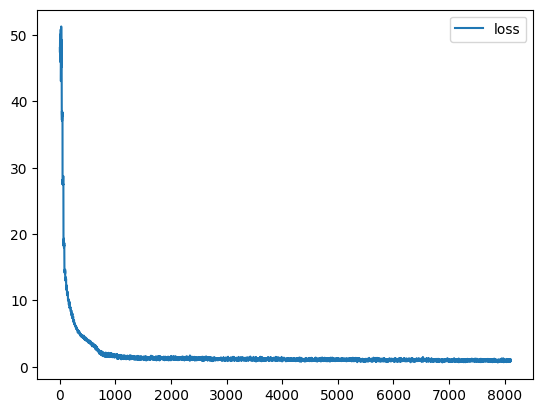

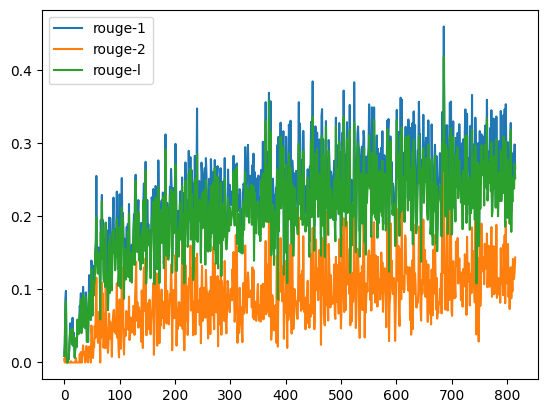

In [8]:
plt.plot(loss_plt_list, label="loss")
plt.legend()
plt.show()
plt.plot(rouge_plt_list["rouge-1"], label="rouge-1")
plt.plot(rouge_plt_list["rouge-2"], label="rouge-2")
plt.plot(rouge_plt_list["rouge-l"], label="rouge-l")
plt.legend()
plt.show()

### Save the result

In [9]:
result_dict = [{"title": title_, "id": str(feature_["id"])} for feature_, title_ in zip(eval_df.iloc, pdt_lst)]

with open(args.result_file, "w") as f:
    for result_pair in result_dict:
        json.dump(result_pair, f)
        f.write("\n")

### Mount Google Drive and Save the Result

In [10]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [11]:
! cp -r /content/model "/content/gdrive/My Drive/ADL/Hw2/model"
! cp /content/result.jsonl "/content/gdrive/My Drive/ADL/Hw2/result.jsonl"